In [1]:
import pyemu
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import shutil
import numpy as np
import sys

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(1, path)
from swatmf import swatmf_pst_utils

In [3]:
# from apexmf import apexmf_pst_viz
# from apexmf.salt.salt_handler import SaltAnalysis
# from apexmf.salt.analyzer import SaltAnalysis, SaltViz, get_stats

In [4]:
# working directory
wd = "D:/test/middle_bosque_1000/SWAT-MODFLOW"
os.chdir(wd)

In [9]:
# test run
pyemu.os_utils.run("pestpp-ies mb_zon.pst",cwd=wd)

In [22]:
# reweight
pst = pyemu.Pst(os.path.join(wd,'mb_zon.pst'))
pst.phi


3002.9504297625426

# Reweight

In [23]:
balanced_groups = {grp:10000 for grp in pst.nnz_obs_groups}
# print(pst.phi) #assumes "my.res" is colocated with "my.pst"
pst.adjust_weights(obsgrp_dict=balanced_groups)

In [12]:
os.getcwd()

'D:\\test\\middle_bosque_1000\\SWAT-MODFLOW'

In [13]:
obs = pst.observation_data.copy()

In [24]:
pst.observation_data = obs

In [25]:
pst.write('mb_zon_rw.pst', version=2)

noptmax:0, npar_adj:7, nnz_obs:305


# Posterior

In [5]:
pst_ies = pyemu.Pst(os.path.join(wd,"mb_zon_rw.pst"))
pst_ies.pestpp_options['ies_num_reals'] = 10
pst_ies.control_data.noptmax = 2
pst_ies.write('mb_zon_rw_ies.pst', version=2)

noptmax:2, npar_adj:7, nnz_obs:305


In [6]:
os.chdir(os.pardir)

In [7]:
os.getcwd()

'D:\\test\\middle_bosque_1000'

In [8]:
m_d = os.path.join(os.getcwd(), "main_zon_rw_ies")

In [9]:
m_d

'D:\\test\\middle_bosque_1000\\main_zon_rw_ies'

In [10]:

num_workers = 5

In [11]:
pyemu.os_utils.start_workers(wd, # the folder which contains the "template" PEST dataset
                            'pestpp-ies', #the PEST software version we want to run
                            'mb_zon_rw_ies.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory,
                            reuse_master=True
                            )

Exception: start_workers() master returned non-zero: 3221226356

In [13]:
pst = pyemu.Pst(os.path.join(m_d,'mb_zon_rw.pst'))

In [14]:
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"mb_zon_rw.0.obs.csv")
    )
pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"mb_zon_rw.{0}.obs.csv".format(pst.control_data.noptmax)))


<Figure size 800x1050 with 0 Axes>

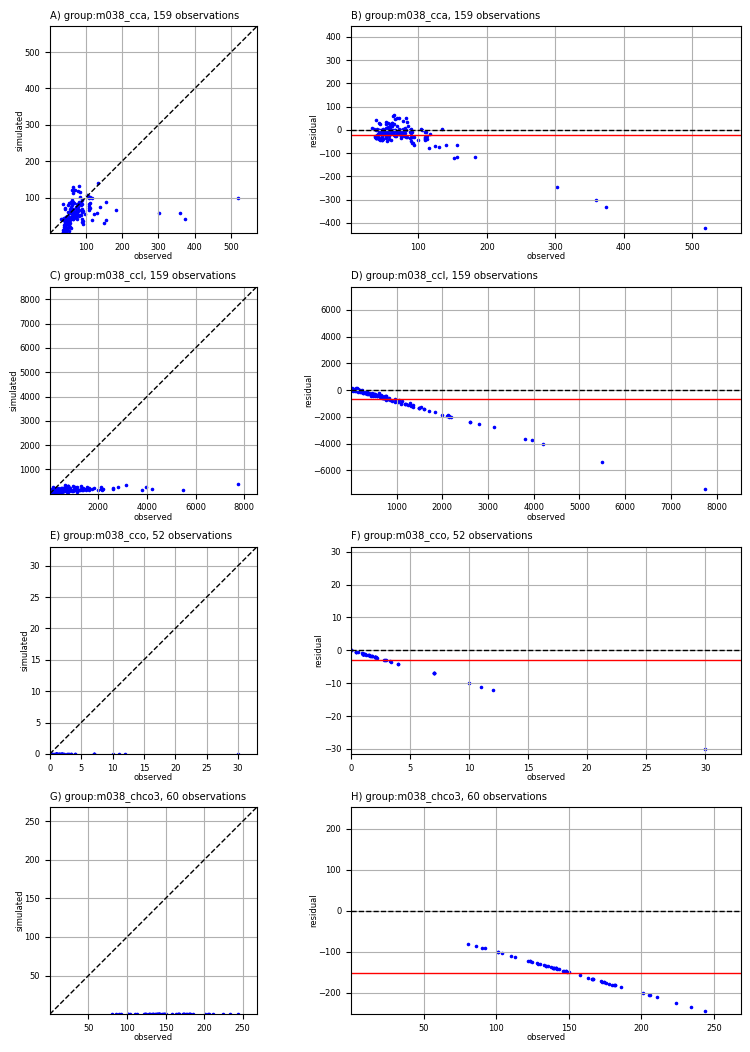

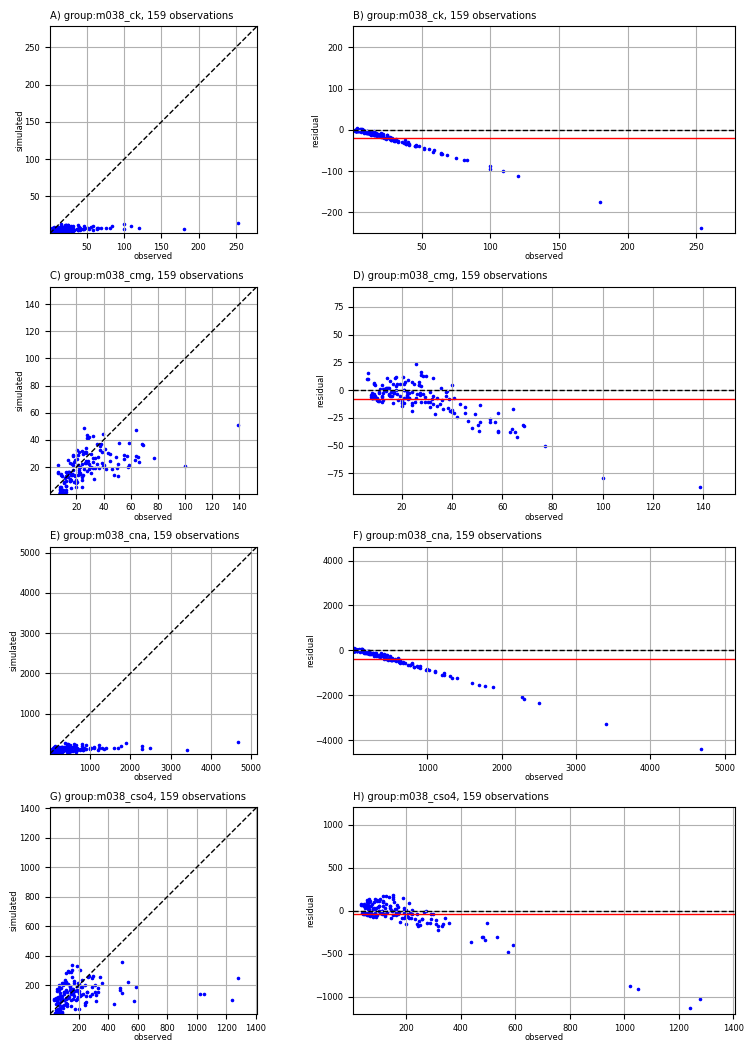

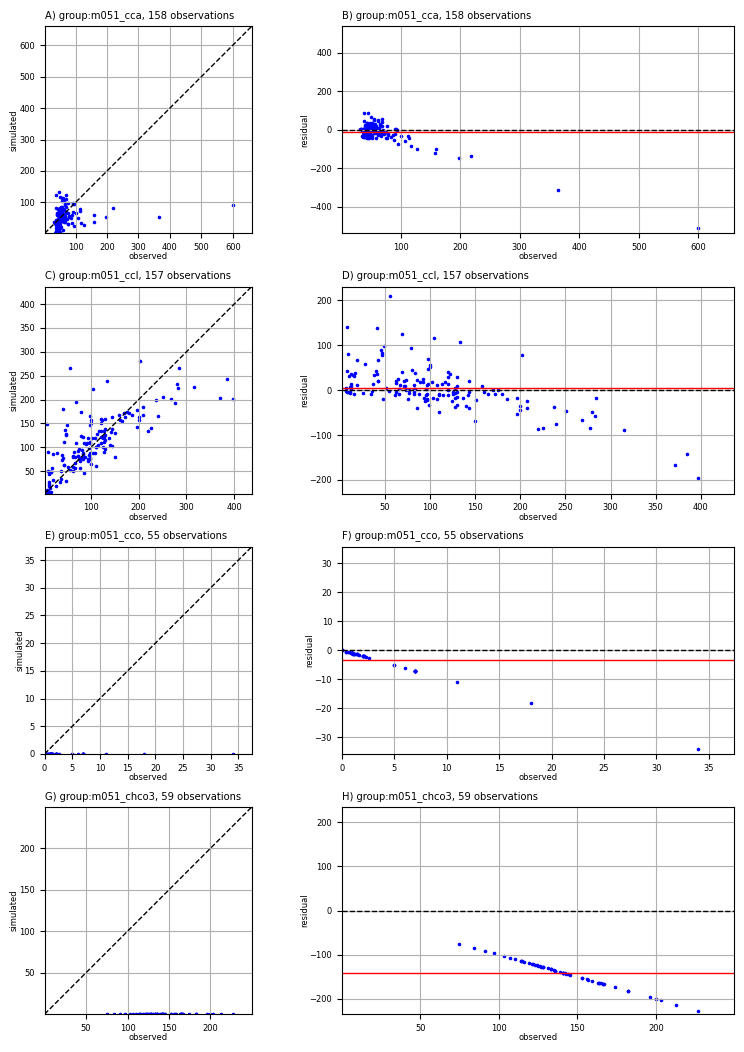

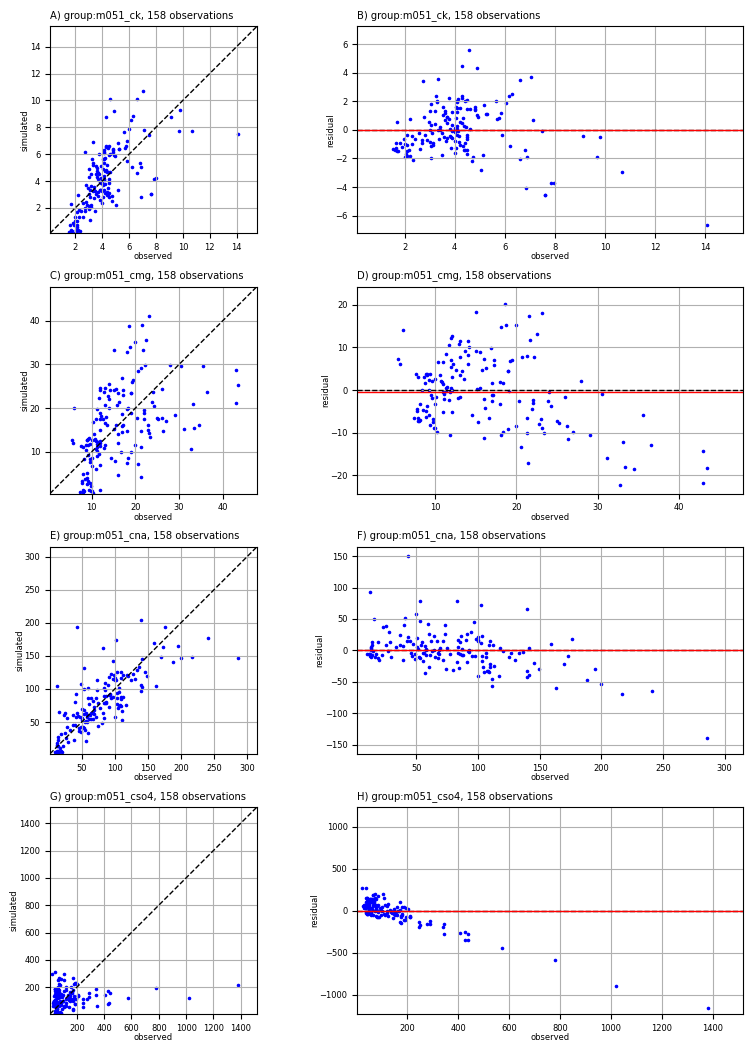

In [15]:
pyemu.plot_utils.res_1to1(pst);

In [16]:
pt_oe.phi_vector

real_name
2       1.338878e+06
4       1.332363e+06
6       1.329407e+06
8       1.337729e+06
9       1.330459e+06
            ...     
294     1.337247e+06
295     1.352584e+06
296     1.345118e+06
298     1.335896e+06
base    1.330788e+06
Length: 206, dtype: float64

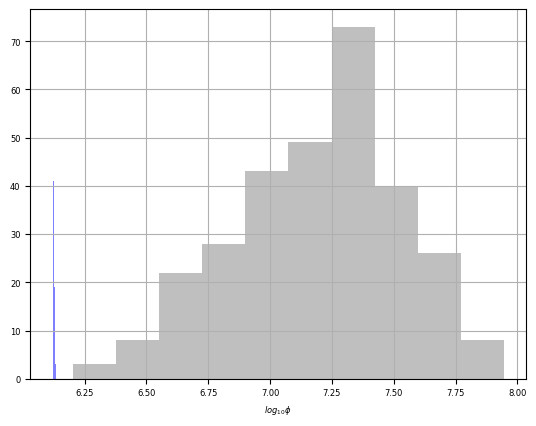

In [17]:
fig,ax = plt.subplots(1,1)
pr_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="0.5",ec="none",alpha=0.5,density=False)
pt_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="b",ec="none",alpha=0.5,density=False)
_ = ax.set_xlabel("$log_{10}\\phi$")

In [20]:
def plot_tseries_ensembles(
                    pr_oe, pt_oe, dot=True,
#                     onames=["hds","sfr"]
                    ):
    pst.try_parse_name_metadata()
    # get the observation data from the control file and select 
    obs = pst.observation_data.copy()
    obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    time_col = []
    for i in range(len(obs)):
        time_col.append(obs.iloc[i, 0][-6:])
    obs.time = time_col
#     # onames provided in oname argument
#     obs = obs.loc[obs.oname.apply(lambda x: x in onames)]
    # only non-zero observations
#     obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    # make a plot
    ogs = obs.obgnme.unique()
    fig,axes = plt.subplots(len(ogs),1,figsize=(20,4*len(ogs)))
    ogs.sort()
    # for each observation group (i.e. timeseries)
    for ax,og in zip(axes,ogs):
        # get values for x axis
        oobs = obs.loc[obs.obgnme==og,:].copy()
        oobs.loc[:,"time"] = oobs.time.astype(str)
#         oobs.sort_values(by="time",inplace=True)
        tvals = oobs.time.values
        onames = oobs.obsnme.values
        if dot is True:
            # plot prior
            [ax.scatter(tvals,pr_oe.loc[i,onames].values,color="gray",s=30, alpha=0.5) for i in pr_oe.index]
            # plot posterior
            [ax.scatter(tvals,pt_oe.loc[i,onames].values,color='b',s=30,alpha=0.2) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.scatter(oobs.time,oobs.obsval,color='red',s=30).set_facecolor("none")
        if dot is False:
            # plot prior
            [ax.plot(tvals,pr_oe.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in pr_oe.index]
            # plot posterior
            [ax.plot(tvals,pt_oe.loc[i,onames].values,"b",lw=0.5,alpha=0.5) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.plot(oobs.time,oobs.obsval,"r-",lw=2)
        ax.tick_params(axis='x', labelrotation=90)
        ax.margins(x=0.01)
        ax.set_title(og,loc="left")
    fig.tight_layout()
    return fig

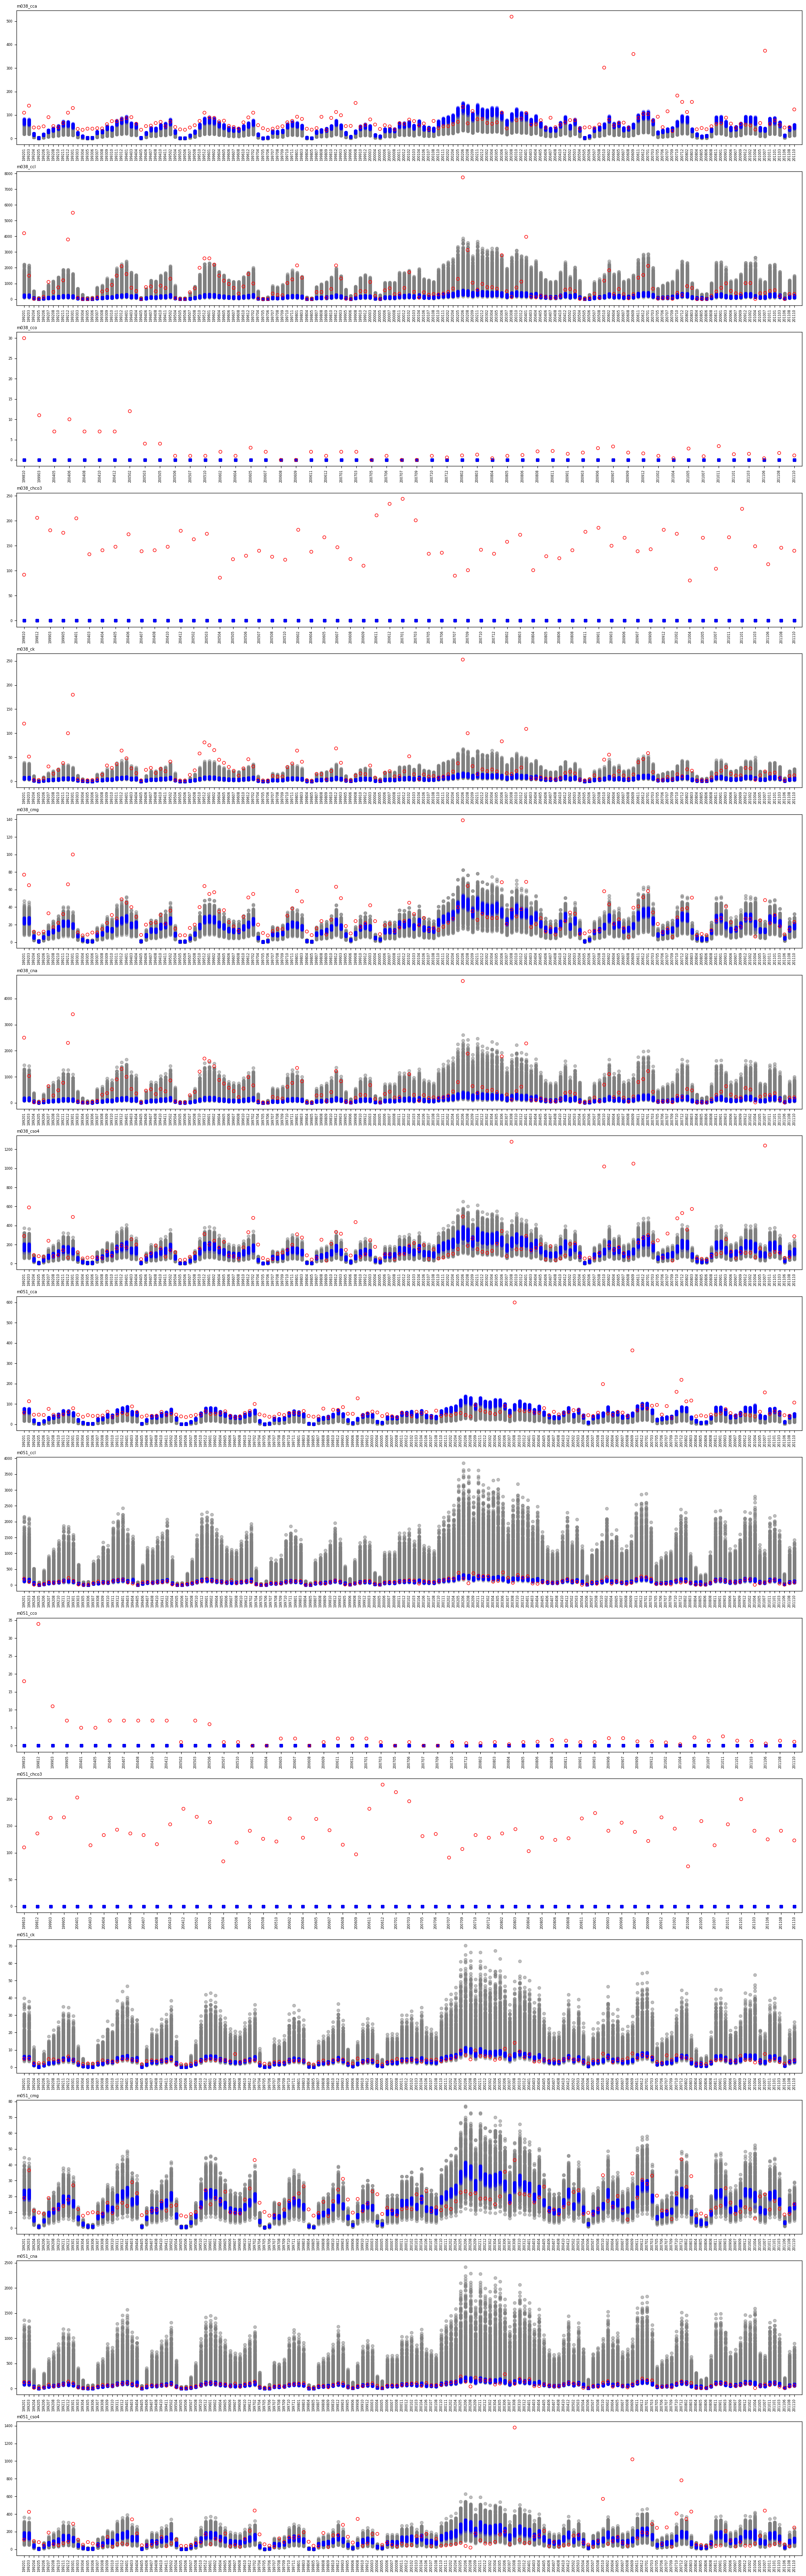

In [21]:
fig = plot_tseries_ensembles(pr_oe, pt_oe, dot=True)

In [26]:
os.getcwd()

'D:\\spark\\animas_amrs'

In [30]:
pst.parrep(parfile=os.path.join(m_d, 'dolores_amrs_pp_rw_ies.7.base.par'))

Updating parameter values from main_ies_1_pp_rw_ies\dolores_amrs_pp_rw_ies.7.base.par
parrep: updating noptmax to 0


In [31]:
# updates the model input files with parameter values
pst.write_input_files(pst_path=m_d)

In [32]:
m_d

'main_ies_1_pp_rw_ies'

In [33]:
# run the model forward run; this applies all the multipler paarameters, executes MODFLOW6 and MODPATH7 and then postprocess observations
os.chdir(m_d)
pyemu.os_utils.run('python salt_forward_run.py')

In [32]:
os.getcwd()

'D:\\spark\\animas_amrs\\main_ies_1_pp_rw_ies'

In [54]:
def salt_viz(model, salt_df, subs):
    for i in subs:
        print(f"{'= = '*3}sub{i:03d} {'= = '*3}")
        sim_df = model.read_salt_sim_cha(salt_df, i, sim_start, cal_start, cal_end).resample('M').mean()
        obd_df = model.read_salt_obd_cha(i, time_step='mon')
        obd_df = obd_df[~obd_df.index.duplicated(keep='first')]    
        for o in obd_df.columns[1:]:
            comdf = model.sim_obd_df(sim_df, o, obd_df, o)
            print(o)
            print(get_stats(comdf['1/1/1992':'12/31/2011']))
            fig, ax = plt.subplots(1, 2, figsize=(12, 2), gridspec_kw={'width_ratios': [6, 1]})
            SaltViz(comdf['1/1/1992':'12/31/2011']).hydro_sim_obd02(ax[0])
            SaltViz(comdf['1/1/1992':'12/31/2011']).reg_line02(ax[1])
            fig.tight_layout()
            plt.show()

In [55]:
m_test = SaltAnalysis(os.getcwd())
salt_test = m_test.load_salt_cha_result()
sim_start = '1/1/1987'
cal_start = '1/1/1992'
cal_end = '12/31/2011'

In [56]:
salt_test

,load_so4,load_ca,load_mg,load_na,load_k,load_cl,load_co3,load_hco3,conc_so4,conc_ca,conc_mg,conc_na,conc_k,conc_cl,conc_co3,conc_hco3
subarea,,,,,,,,,,,,,,,,
1,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
2,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
3,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
4,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
5,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,15118.79600,3665.69410,1601.367400,15230.84700,799.208800,25797.78300,0.008430,0.008430,539.82312,130.88518,57.177509,543.82391,28.536093,921.12097,0.000301,0.000301
156,14187.06900,3429.47410,1517.290300,14263.23500,751.031740,24775.74400,0.008362,0.008362,522.03894,126.19372,55.831448,524.84161,27.635576,911.66846,0.000308,0.000308
157,14158.77300,3422.67380,1515.032200,14238.01700,749.833620,24746.59800,0.008362,0.008362,522.22382,126.23988,55.879555,525.14661,27.656420,912.73889,0.000308,0.000308


= = = = = = sub038 = = = = = = 
conc_co3
(-0.4148, 5.5549, 99.9995, 0.0887)


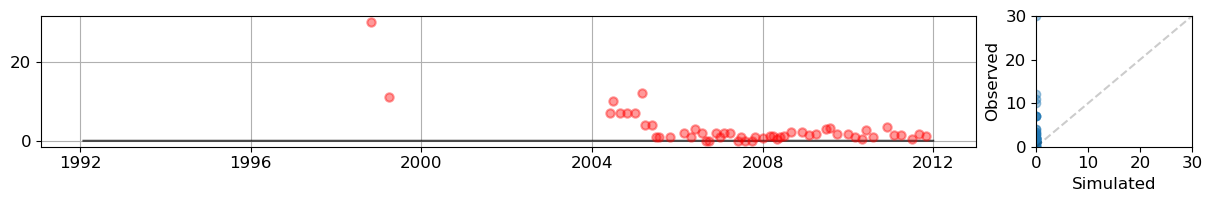

conc_hco3
(-18.017, 155.0808, 100.0, 0.0181)


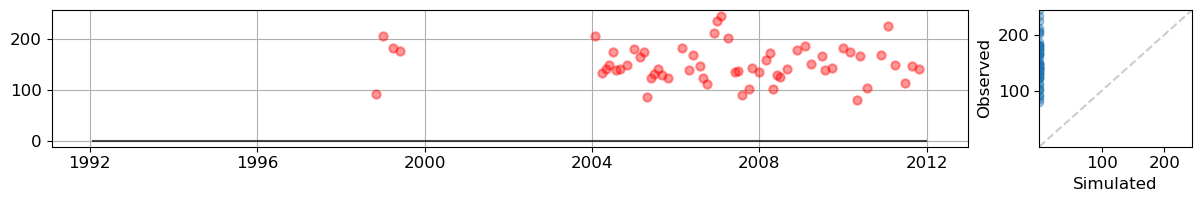

conc_ca
(-0.1327, 62.1657, 28.546, 0.074)


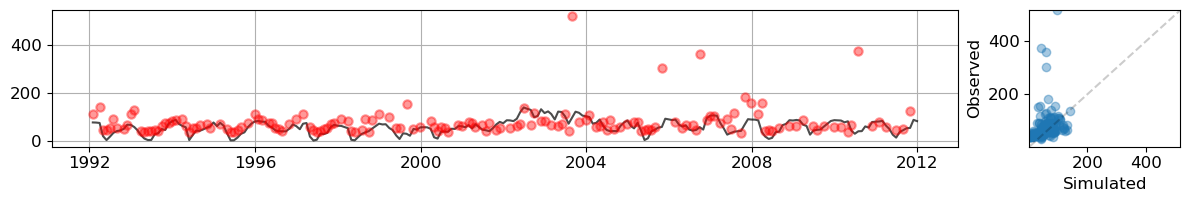

conc_mg
(0.1698, 17.3524, 29.1892, 0.3503)


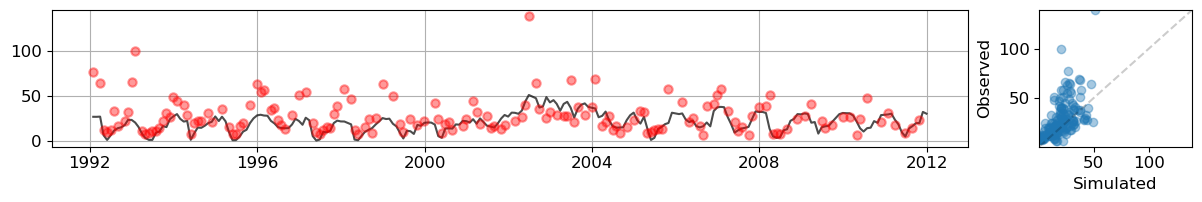

conc_na
(-0.278, 700.7599, 77.4409, 0.2459)


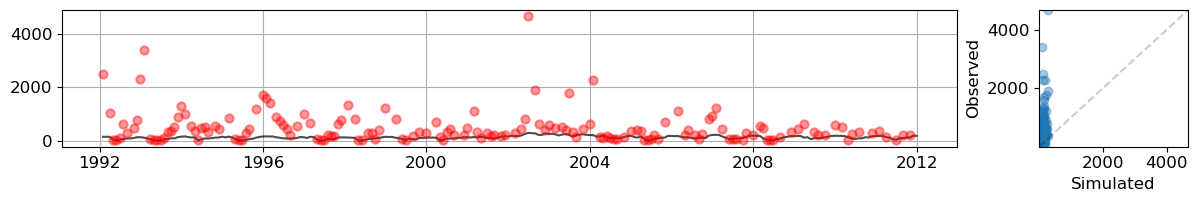

conc_k
(-0.3021, 35.55, 78.3711, 0.2336)


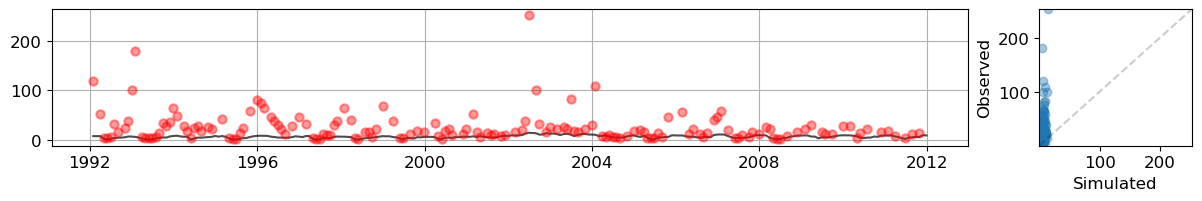

conc_cl
(-0.3054, 1173.4815, 81.0131, 0.2494)


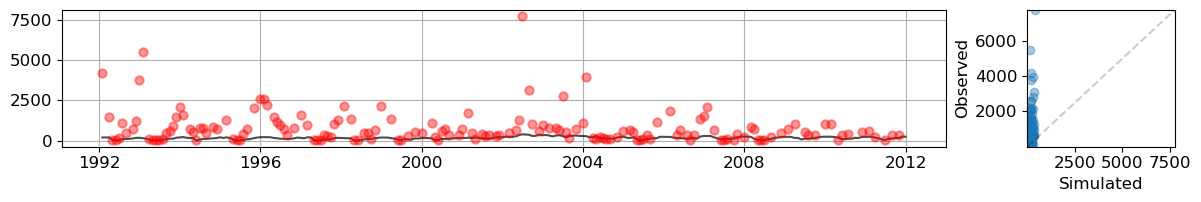

conc_so4
(-0.0008, 192.8043, 24.7636, 0.0721)


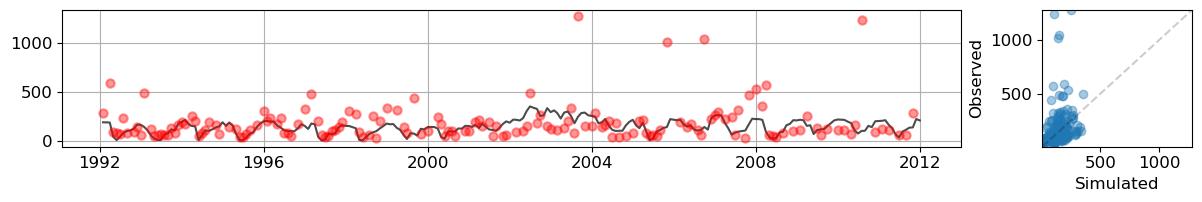

load_co3
(-0.1271, 3707.1599, 99.9995, 0.0065)


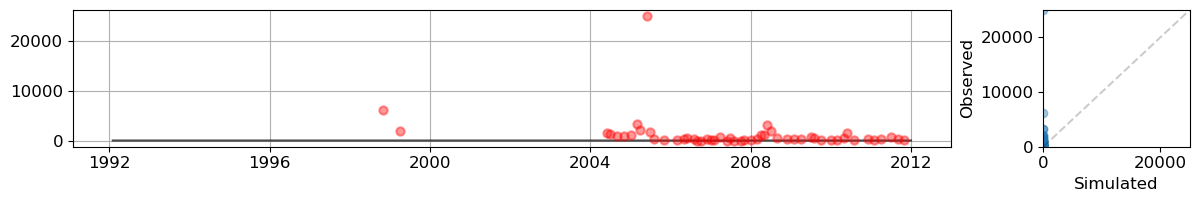

load_hco3
(-0.3752, 147562.3031, 100.0, 0.1213)


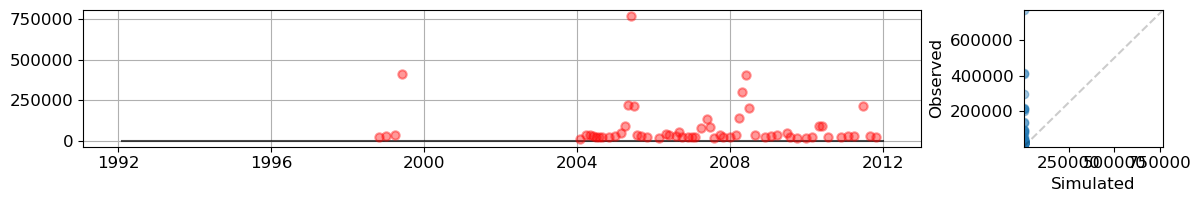

load_ca
(-0.1347, 63756.2738, 71.5742, 0.1878)


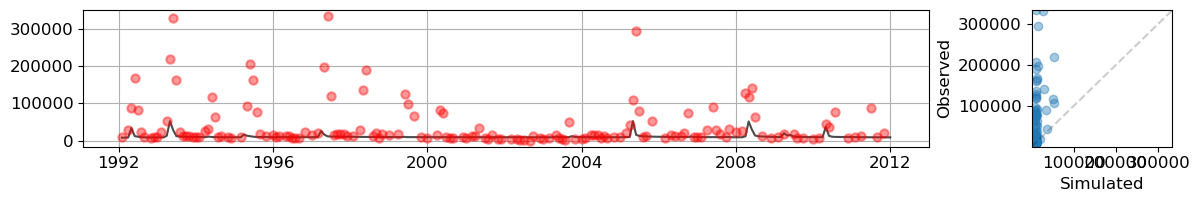

load_mg
(-0.1471, 14898.5841, 63.6985, 0.1499)


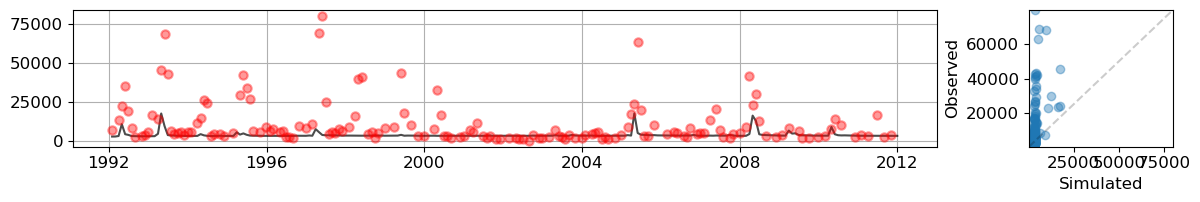

load_na
(-0.6771, 113410.527, 75.9268, 0.0041)


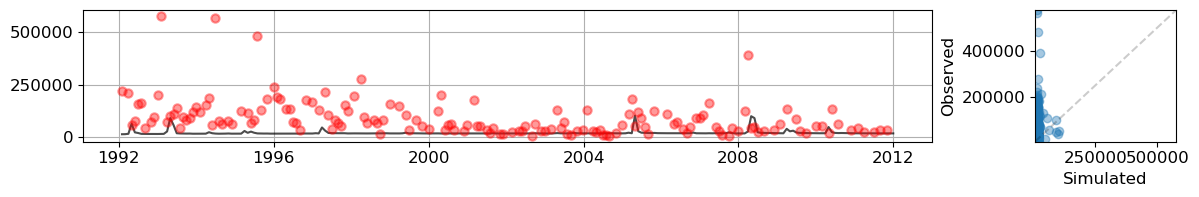

load_k
(-0.8071, 6295.4095, 79.5017, 0.0335)


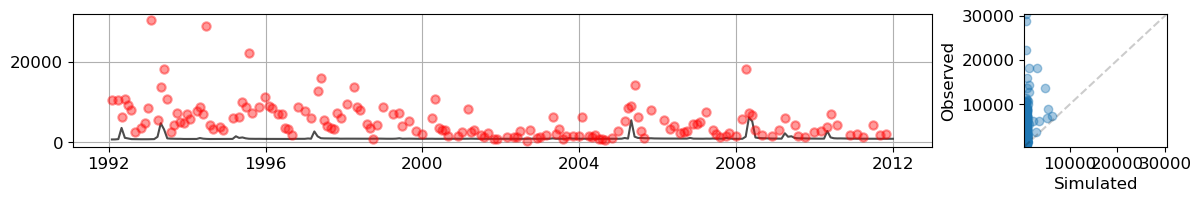

load_cl
(-0.6442, 180078.866, 77.4019, 0.0153)


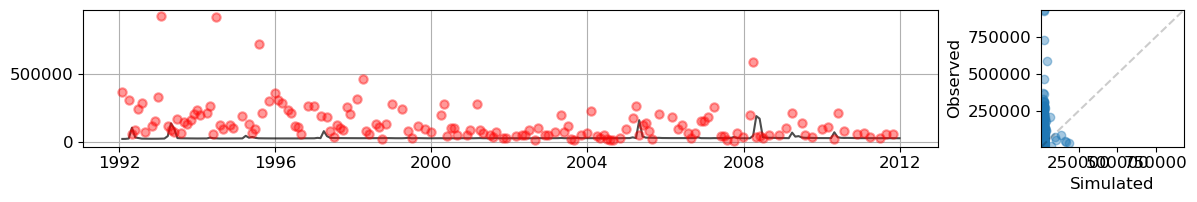

load_so4
(-0.1216, 111406.7721, 63.685, 0.1386)


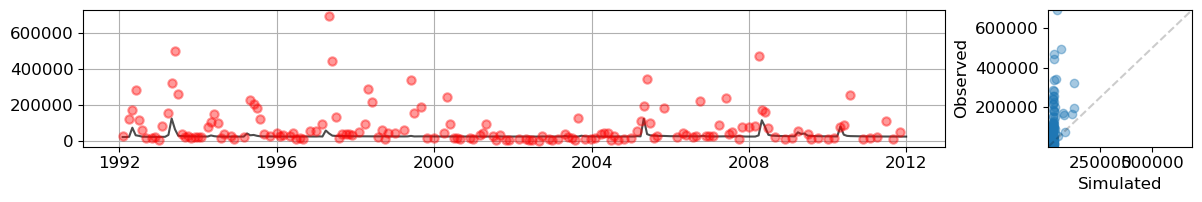

In [57]:
salt_viz(m_test, salt_test, [38])

In [63]:
m_d2 = "D:/spark/dolores_amrs/main_ies_1_pp_rw_ies/"

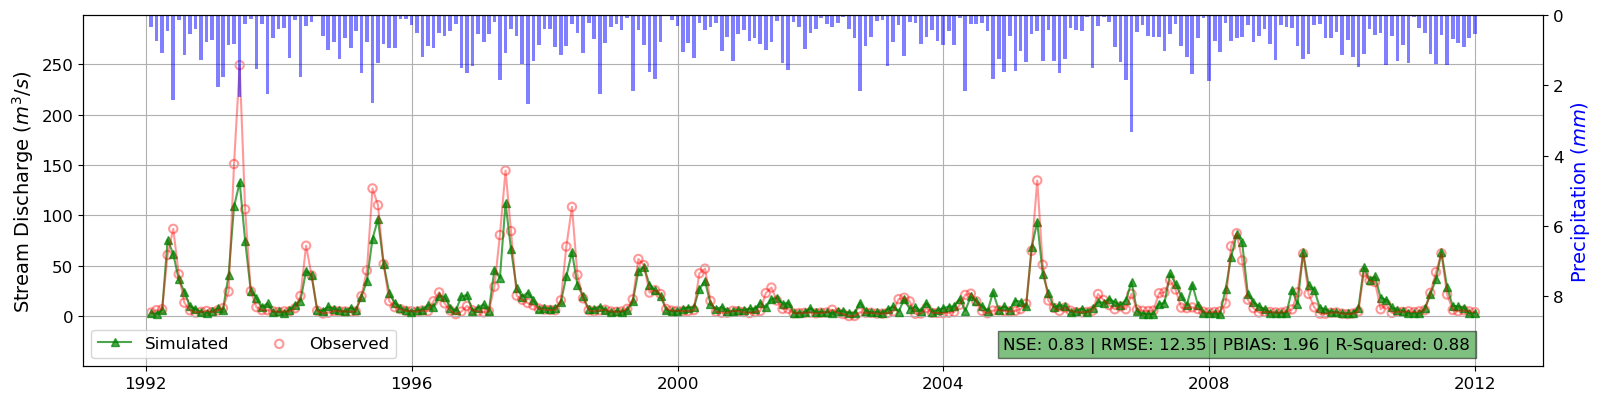

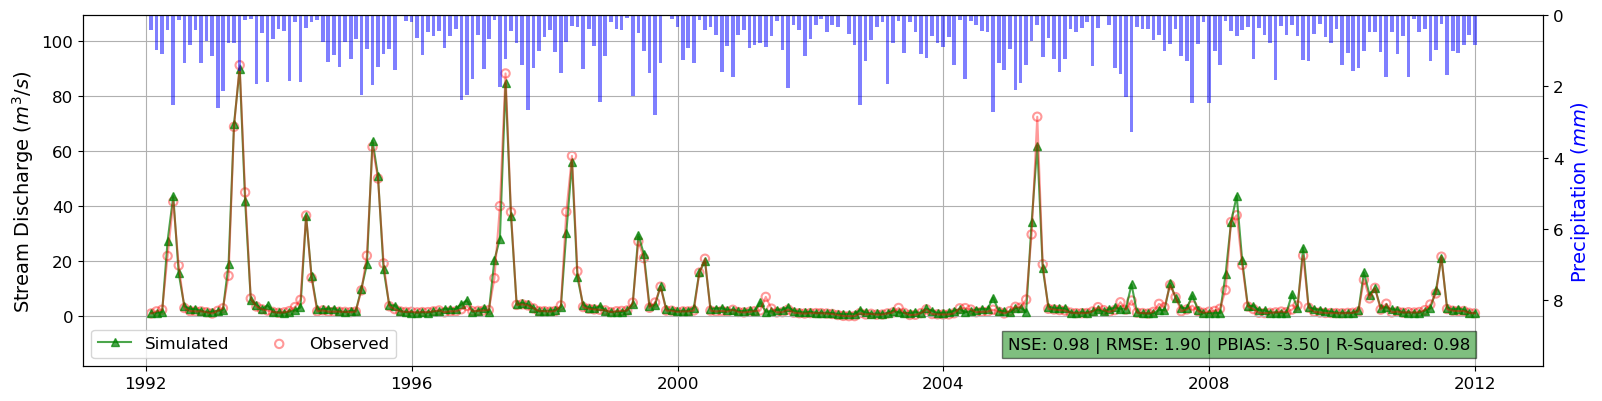

In [65]:
# wd = 'D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/v02_calibrated'
os.chdir(os.path.join(m_d2))
str_dic = {1:'sub001', 38:'sub038'}
for sim, obd in str_dic.items():
    pdf = apexmf_pst_viz.stf_df('SITE1.RCH', '1/1/1987', sim, obd, time_step='M')
    apexmf_pst_viz.stf_plot(pdf['1/1/1992':'12/31/2011'])
#     apexmf_pst_viz.str_plot(pdf['1/1/2010':'12/31/2019'])
# mf_dic = {5895:'wt_gw_124'}
# for sim, obd in mf_dic.items():
#     mfdf = apexmf_pst_viz.wt_df('1/1/1987', sim, obd, prep_sub=75)
#     # apexmf_pst_viz.wt_plot(mfdf['1/1/2010':'12/31/2019'])
#     apexmf_pst_viz.wt_plot(mfdf['1/1/1992':'12/31/2011'])